In [51]:
import sys
print(sys.prefix != sys.base_prefix) # true if in venv
sys.version # 3.11.6

False


'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

Import pandas library as pd for brevity.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing

## Fix empty timestamps

In [53]:
def missing_daily_values(df: pd.DataFrame, start='2018-08-01 04:00:00',end='2022-09-15 09:00:00'):
    """index must be a DateTimeIndex for this function to make sense"""
    missingDatetimes = pd.date_range(start=start, end=end, freq='h').difference(df.index)
    missingDf = pd.DataFrame(index=missingDatetimes, data=np.ones(missingDatetimes.size))
    missingDfHours = missingDf.resample(rule='d').sum(min_count=1)
    missingDfHours.dropna(inplace=True)
    return missingDfHours

def missing_hours_series(df: pd.DataFrame, start='2018-08-01 04:00:00',end='2022-09-15 09:00:00'):
    """index must be a DateTimeIndex for this function to make sense"""
    missingDatetimes = pd.date_range(start=start, end=end, freq='h').difference(df.index)
    return missingDatetimes.to_series()

def contiguous_hours(s: pd.Series):
    """series s must be of TimeStamp type (hourly data) for this function to make sense"""
    threshold = pd.Timedelta(hours=1)

    # Calculate the differences between consecutive datetime values
    diffs = s.diff()

    # Identify groups of contiguous datetime values
    groups = (diffs > threshold).cumsum()

    # Aggregate contiguous groups
    result = s.groupby(groups).agg(['min', 'max']).reset_index(drop=True)
    result['time']=result['max']-result['min']
    result.rename(columns={"min": "From", "max": "To"},inplace=True)
    return result

def fill_last_24_hours(df:pd.DataFrame): # its last 23 + current
    """Index must be (hourly) timeseries"""
    temp=pd.DataFrame([])
    for i in range(24):
        temp=temp.join(df.shift(i,freq='h'),how='outer',rsuffix=' t-'+str(i))
    return temp

def fill_last_X_hours(df:pd.DataFrame,X):
    """Index must be (hourly) timeseries"""
    temp=pd.DataFrame([])
    for i in range(X):
        temp=temp.join(df.shift(i,freq='h'),how='outer',rsuffix=' t-'+str(i))
    return temp

def fill_last_24_hours_plus_5_ahead(df:pd.DataFrame): # its last 23 + current
    """Index must be (hourly) timeseries"""
    temp=pd.DataFrame([])
    for i in range(24):
        temp=temp.join(df.shift(i,freq='h'),how='outer',rsuffix=' t-'+str(i))
    for i in range(5):
        temp=df.shift(-(i+1),freq='h').join(temp,how='outer',lsuffix=' t+'+str(i+1))
    return temp

### Gas flows

In [54]:
df_gas0=pd.read_csv('stratos_data/desfa_stratos_hourly_gas_flow_enum0.csv',delimiter=',',parse_dates=['refRealDateTimeFrom_inZone'],index_col=['refRealDateTimeFrom_inZone'])
df_gas1=pd.read_csv('stratos_data/desfa_stratos_hourly_gas_flow_enum1.csv',delimiter=',',parse_dates=['refRealDateTimeFrom_inZone'],index_col=['refRealDateTimeFrom_inZone'])

print(contiguous_hours(missing_hours_series(df=df_gas0,start=df_gas0.index.min(),end=df_gas0.index.max())))
print(contiguous_hours(missing_hours_series(df=df_gas1,start=df_gas1.index.min(),end=df_gas1.index.max())))


                 From                  To            time
0 2019-03-15 23:00:00 2019-03-16 05:00:00 0 days 06:00:00
1 2021-10-31 00:00:00 2021-10-31 00:00:00 0 days 00:00:00
                 From                  To            time
0 2019-03-15 23:00:00 2019-03-16 05:00:00 0 days 06:00:00
1 2021-10-31 00:00:00 2021-10-31 00:00:00 0 days 00:00:00


In [55]:
df_gas0.size

30708

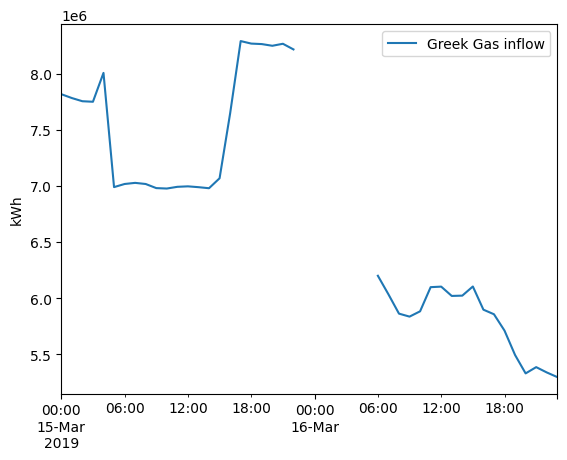

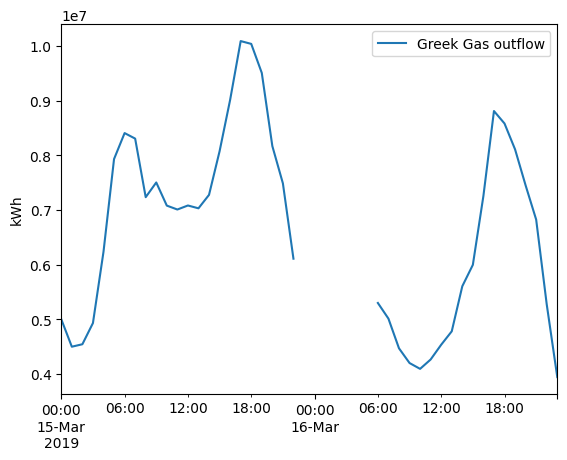

In [56]:
temp_plot0=df_gas0['2019-03-15':'2019-03-16'].resample('h').max().plot() # resample for NA
temp_plot1=df_gas1['2019-03-15':'2019-03-16'].resample('h').max().plot()
temp_plot0.set_xlabel('')
temp_plot0.set_ylabel('kWh')
temp_plot0.legend(['Greek Gas inflow'])
temp_plot1.set_xlabel('')
temp_plot1.set_ylabel('kWh')
temp_plot1.legend(['Greek Gas outflow'])

Με βάση τα προηγούμενα θα κάνουμε linear interpolate για το 0,1 και θα αφαιρέσουμε το διάστημα 2 (13/8/22-7/9/22)

Empty DataFrame
Columns: [From, To, time]
Index: []
Empty DataFrame
Columns: [From, To, time]
Index: []


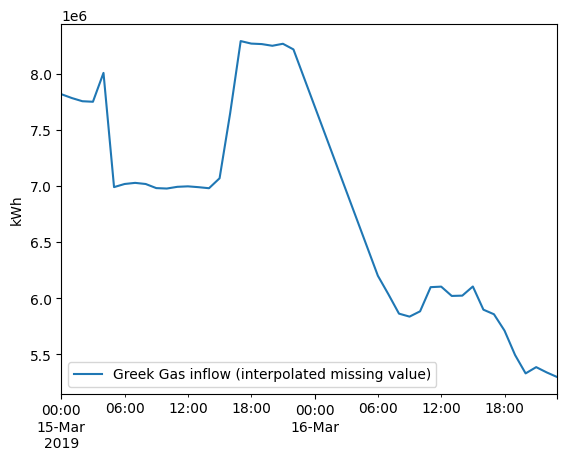

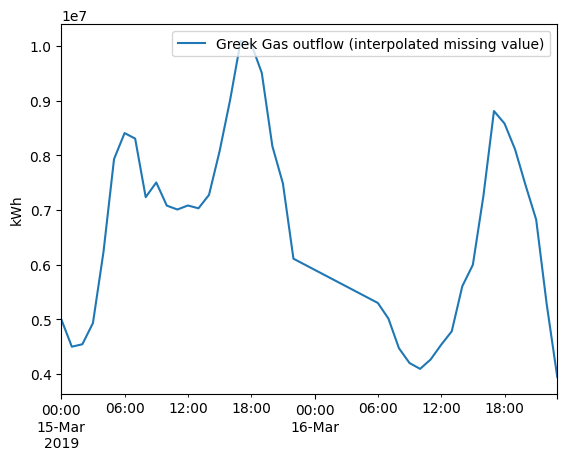

In [57]:
df_gas0=df_gas0.resample('h').max()
# print(df_gas0['2019-03-15 21':'2019-03-16 08'])

df_gas0['2019-03-15':'2019-03-16']=df_gas0['2019-03-15':'2019-03-16'].interpolate('linear')
# print(df_gas0['2019-03-15 21':'2019-03-16 08'])
df_gas0['2021-10-30 20':'2021-10-31 02']=df_gas0['2021-10-30 20':'2021-10-31 02'].interpolate('linear')
# print(df_gas0['2021-10-30 20':'2021-10-31 02'])

df_gas0=df_gas0.dropna()
print(contiguous_hours(missing_hours_series(df=df_gas0,start=df_gas0.index.min(),end=df_gas0.index.max())))

df_gas1=df_gas1.resample('h').max()

df_gas1['2019-03-15':'2019-03-16']=df_gas1['2019-03-15':'2019-03-16'].interpolate('linear')
df_gas1['2021-10-30 20':'2021-10-31 02']=df_gas1['2021-10-30 20':'2021-10-31 02'].interpolate('linear')

df_gas1=df_gas1.dropna()
print(contiguous_hours(missing_hours_series(df=df_gas1,start=df_gas1.index.min(),end=df_gas1.index.max())))

temp_plot0=df_gas0['2019-03-15':'2019-03-16'].plot()
temp_plot1=df_gas1['2019-03-15':'2019-03-16'].plot()

temp_plot0.set_xlabel('')
temp_plot0.set_ylabel('kWh')
temp_plot0.legend(['Greek Gas inflow (interpolated missing value)'])
temp_plot1.set_xlabel('')
temp_plot1.set_ylabel('kWh')
temp_plot1.legend(['Greek Gas outflow (interpolated missing value)'])



### Solar

In [58]:
df_solar=pd.read_csv('stratos_data/entsoe_stratos_solar.csv',delimiter=',',parse_dates=['DateTime'],index_col=['DateTime'])
df_solar.rename(columns={"AggregatedGenerationForecast": "SolarGenForecast"},inplace=True)

print('Ελλιπή δεδομένα πρόβλεψης παραγωγής ηλιακής ενέργειας:')
print(contiguous_hours(missing_hours_series(df=df_solar,start=df_solar.index.min(),end=df_solar.index.max())).iloc[:,0:2])

# df_solar.head(4)

Ελλιπή δεδομένα πρόβλεψης παραγωγής ηλιακής ενέργειας:
                  From                  To
0  2019-03-17 22:00:00 2019-03-18 21:00:00
1  2019-04-30 21:00:00 2019-05-03 20:00:00
2  2019-05-19 21:00:00 2019-05-21 20:00:00
3  2019-05-24 21:00:00 2019-05-25 20:00:00
4  2019-05-28 21:00:00 2019-06-01 20:00:00
5  2019-06-04 21:00:00 2019-06-22 20:00:00
6  2019-07-09 21:00:00 2019-07-11 20:00:00
7  2019-07-15 21:00:00 2019-07-17 20:00:00
8  2019-07-23 21:00:00 2019-07-25 20:00:00
9  2019-07-29 21:00:00 2019-08-01 20:00:00
10 2020-01-07 22:00:00 2020-01-12 21:00:00
11 2020-01-13 22:00:00 2020-01-14 21:00:00
12 2020-01-16 22:00:00 2020-01-18 21:00:00
13 2020-01-20 22:00:00 2020-01-26 21:00:00
14 2020-01-27 22:00:00 2020-01-28 21:00:00
15 2020-01-30 22:00:00 2020-02-05 21:00:00
16 2020-02-09 22:00:00 2020-02-13 21:00:00
17 2020-05-25 21:00:00 2020-05-26 20:00:00
18 2020-06-02 21:00:00 2020-06-03 20:00:00
19 2020-08-26 21:00:00 2020-08-27 20:00:00
20 2020-08-31 21:00:00 2020-09-01 20:00:00

### Wind

In [59]:
df_wind=pd.read_csv('stratos_data/entsoe_stratos_wind_forecast.csv',delimiter=',',parse_dates=['DateTime'],index_col=['DateTime'])
df_wind.rename(columns={"AggregatedGenerationForecast": "WindGenForecast"},inplace=True)
print('Ελλιπή δεδομένα πρόβλεψης παραγωγής αιολικής ενέργειας:')
print(contiguous_hours(missing_hours_series(df=df_wind,start=df_wind.index.min(),end=df_wind.index.max())).iloc[:,0:2])


Ελλιπή δεδομένα πρόβλεψης παραγωγής αιολικής ενέργειας:
                  From                  To
0  2018-08-27 21:00:00 2018-08-28 20:00:00
1  2019-03-17 22:00:00 2019-03-18 21:00:00
2  2019-04-30 21:00:00 2019-05-03 20:00:00
3  2019-05-19 21:00:00 2019-05-21 20:00:00
4  2019-05-24 21:00:00 2019-05-25 20:00:00
5  2019-05-28 21:00:00 2019-06-01 20:00:00
6  2019-06-04 21:00:00 2019-06-22 20:00:00
7  2019-07-09 21:00:00 2019-07-11 20:00:00
8  2019-07-15 21:00:00 2019-07-17 20:00:00
9  2019-07-23 21:00:00 2019-07-25 20:00:00
10 2019-07-29 21:00:00 2019-08-01 20:00:00
11 2020-01-07 22:00:00 2020-01-12 21:00:00
12 2020-01-13 22:00:00 2020-01-14 21:00:00
13 2020-01-16 22:00:00 2020-01-18 21:00:00
14 2020-01-20 22:00:00 2020-01-26 21:00:00
15 2020-01-27 22:00:00 2020-01-28 21:00:00
16 2020-01-30 22:00:00 2020-02-05 21:00:00
17 2020-02-09 22:00:00 2020-02-13 21:00:00
18 2020-05-25 21:00:00 2020-05-26 20:00:00
19 2020-06-02 21:00:00 2020-06-03 20:00:00
20 2020-08-26 21:00:00 2020-08-27 20:00:0

### Total load

In [60]:
df_load=pd.read_csv('stratos_data/entsoe_stratos_total_load_forecast.csv',delimiter=',',parse_dates=['DateTime'],index_col=['DateTime'])

z=missing_daily_values(df_load)
print("no missing values" if z.empty else "")



In [61]:
print('gas0',df_gas0.index.size)
print('gas1',df_gas1.index.size)
print('wind',df_wind.index.size)
print('solr',df_solar.index.size)
print('load',df_load.index.size)

gas0 30716
gas1 30716
wind 34128
solr 34152
load 35808


<Axes: xlabel='DateTime'>

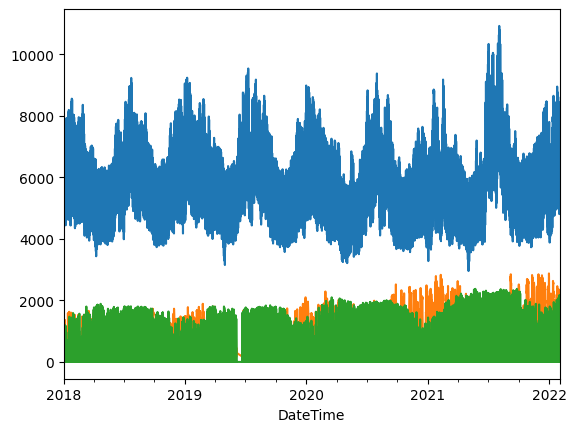

In [62]:
df_load['TotalLoadForecast'].plot()
df_wind['WindGenForecast'].plot()
df_solar['SolarGenForecast'].plot()

## Fill with previous values

In [63]:
df_solar_24=fill_last_X_hours(df_solar,X=24).dropna(axis='index')
df_solar_48=fill_last_X_hours(df_solar,X=48).dropna(axis='index')
df_solar_72=fill_last_X_hours(df_solar,X=72).dropna(axis='index')

df_wind_24=fill_last_X_hours(df_wind,X=24).dropna(axis='index')
df_wind_48=fill_last_X_hours(df_wind,X=48).dropna(axis='index')
df_wind_72=fill_last_X_hours(df_wind,X=72).dropna(axis='index')

df_load_24=fill_last_X_hours(df_load,X=24).dropna(axis='index')
df_load_48=fill_last_X_hours(df_load,X=48).dropna(axis='index')
df_load_72=fill_last_X_hours(df_load,X=72).dropna(axis='index')


In [64]:
predicted=df_gas0.join(df_gas1,lsuffix='0 inflow',rsuffix='1 outflow',how='inner')
# assuming that our forecast is logged a day earlier, we need to shift either the forecasts
# or the predicted value(s). Ill shift the predicted value(s) one day ahead
# Reason: if we have a row of forecast values, we won't have to shift them before running our regression/nn.
predicted=predicted.shift(freq='d')
predicted

,sum(physicalFlow)0 inflow,sum(physicalFlow)1 outflow
refRealDateTimeFrom_inZone,,
2018-08-02 04:00:00,5332486.0,4084033.0
2018-08-02 05:00:00,5425152.0,4611564.0
2018-08-02 06:00:00,5411656.0,5204580.0
2018-08-02 07:00:00,5792693.0,5379787.0
2018-08-02 08:00:00,5735920.0,5706807.0
...,...,...
2022-02-01 19:00:00,9511825.0,11423240.0
2022-02-01 20:00:00,9578271.0,9706134.0
2022-02-01 21:00:00,9554171.0,8507653.0


In [65]:

features=df_wind.join(df_solar,how='inner').join(df_load,how='inner')
df_all=features.join(predicted,how='inner')
print(df_all[df_all['sum(physicalFlow)0 inflow']<10])
data=df_all[df_all['sum(physicalFlow)0 inflow'] > 10]
data.to_csv('data.csv')

                     WindGenForecast  SolarGenForecast  TotalLoadForecast  \
2021-10-31 23:00:00            733.0               0.0             4199.0   
2021-12-13 19:00:00           1420.0               0.0             7175.0   
2021-12-13 20:00:00           1454.0               0.0             6507.0   
2021-12-13 21:00:00           1488.0               0.0             6004.0   
2021-12-13 22:00:00           1407.0               0.0             5425.0   
2021-12-13 23:00:00           1418.0               0.0             4925.0   
2021-12-14 00:00:00           1464.0               0.0             4829.0   
2021-12-14 01:00:00           1512.0               0.0             4709.0   
2021-12-14 02:00:00           1550.0               0.0             4664.0   
2021-12-14 03:00:00           1595.0               0.0             4795.0   
2021-12-14 04:00:00           1646.0               0.0             5308.0   

                     sum(physicalFlow)0 inflow  sum(physicalFlow)1 outflow 

In [66]:
features_24=df_wind_24.join(df_solar_24,how='inner').join(df_load_24,how='inner')
df_all_24=features_24.join(predicted,how='inner')

data_24=df_all_24[df_all_24['sum(physicalFlow)0 inflow'] > 10]
data_24.to_csv('data_24.csv')

In [67]:
features_72=df_wind_72.join(df_solar_72,how='inner').join(df_load_72,how='inner')
df_all_72=features_72.join(predicted,how='inner')

data_72=df_all_72[df_all_72['sum(physicalFlow)0 inflow'] > 10]
data_72.to_csv('data_72.csv')